In [8]:
import turtle
import glfw
from sys import exit
from p5 import *
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

ModuleNotFoundError: No module named 'input_data'

In [ ]:
if not os.path.exists('out/'):
    os.makedirs('out/')

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

mb_size = 16
h_dim = 36

# Recognition/inference weight
R = np.random.randn(X_dim, h_dim) * 0.001
# Generative weight
W = np.random.randn(h_dim, X_dim) * 0.001
# Generative bias of hidden variables
B = np.random.randn(h_dim) * 0.001


def sigm(x):
    return 1/(1 + np.exp(-x))


def infer(X):
    # mb_size x x_dim -> mb_size x h_dim
    return sigm(X @ R)


def generate(H):
    # mb_size x h_dim -> mb_size x x_dim
    return sigm(H @ W)


# Wake-Sleep Algorithm
# --------------------
alpha = 0.1

for t in range(1, 1001):
    # ----------
    # Wake phase
    # ----------

    # Upward pass
    X_mb = (mnist.train.next_batch(mb_size)[0] > 0.5).astype(np.float)
    H = np.random.binomial(n=1, p=infer(X_mb))

    # Downward pass
    H_prime = sigm(B)
    V = generate(H)

    # Compute gradient
    dB = H - H_prime
    dW = np.array([np.outer(H[i], X_mb[i] - V[i]) for i in range(mb_size)])

    # Update generative weight
    B += (alpha/t) * np.mean(dB, axis=0)
    W += (alpha/t) * np.mean(dW, axis=0)

    # -----------
    # Sleep phase
    # -----------

    # Downward pass
    H_mb = np.random.binomial(n=1, p=sigm(B))
    V = np.random.binomial(n=1, p=generate(H_mb))

    # Upward pass
    H = infer(V)

    # Compute gradient
    dR = np.array([np.outer(V, H_mb[i] - H[i]) for i in range(mb_size)])

    # Update recognition weight
    R += (alpha/t) * np.mean(dR, axis=0)


# Visualization
# -------------

def plot(samples, size, name):
    size = int(size)
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(size, size), cmap='Greys_r')

    plt.savefig('out/{}.png'.format(name), bbox_inches='tight')
    plt.close(fig)


X = (mnist.test.next_batch(mb_size)[0] > 0.5).astype(np.float)

H = np.random.binomial(n=1, p=infer(X))
plot(H, np.sqrt(h_dim), 'H')

X_recon = np.random.binomial(n=1, p=generate(H))
plot(X_recon, np.sqrt(X_dim), 'V')

In [ ]:
# Artblocks injects the tokenData variable into your sketch like so
tokenData = {"hash":"0x31f2d12d85e8aeea04e79dc9ed6d3fd2377de7d17fe4233e8c34aab4b48f0f63","tokenId":"18000000"}

# another example if you want to uncomment it to try it out
#tokenData = {"hash":"0xf79f00793c585e9272d46d0437f04580a5fe9b8ebd834b6ce101f18e05d7cb16","tokenId":"18000258"}

In [ ]:
# Gets you an array of 32 parameters from the hash ranging from 0-255
rawParams = setupParametersFromTokenData(tokenData)

# your random seed
seed = generateSeedFromTokenData(tokenData)

# the ID of the token
tokenId = parseInt(tokenData.tokenId.substring(2))


In [ ]:
// params you can use throughout
let params = {
  // map param 0 from 0-255 to 0.1 - 0.4
  radius: mapParam(rawParams[0], 0.1, 0.4),
  // map param 1 from 0-255 to 3-8 as integer
  points: parseInt(mapParam(rawParams[1], 3, 8)),
  // 50% chance to fill
  fill: rawParams[2] < 127,
  // generate a random RGB color
  backgroundColor: "rgb("+rawParams[3]+","+rawParams[4]+","+ rawParams[5]+")"
}

function setup() {
  let dim = Math.min(window.innerWidth, window.innerHeight)
  createCanvas(dim, dim)
  noLoop();
}

function draw() {
  background(params.backgroundColor)
  
  if (params.fill) {
    fill('black')
  } else {
    noFill()
  }
	
  let r = params.radius * width
	
  beginShape()
  
  for (let i=0; i < params.points; i++) {
    let ang = TWO_PI * i/params.points
		
    // slightly offset the angle of each point
    let angleOffset = range(0, TWO_PI)/10
		
    let x = r*cos(ang+angleOffset)
    let y = r*sin(ang+angleOffset)
		
    vertex(x+width/2, y+height/2)	
  }
  endShape(CLOSE)

}

/*
  Helper functions
*/

// parse parameters
function setupParametersFromTokenData(token) {
  let hashPairs = []
  //parse hash
  for (let j = 0; j < 32; j++) {
    hashPairs.push(tokenData.hash.slice(2 + (j * 2), 4 + (j * 2)))
  }
  // map to 0-255
  return hashPairs.map(x => {
    return parseInt(x, 16)
  })
}

function generateSeedFromTokenData(token) {
  return parseInt(tokenData.hash.slice(0, 16), 16)
}

/*
  Random setup and helper functions, some of these are taken from
  @mattdesl's canvas-sketch-util Random library and adapted to work
  with this
*/

function rnd () {
  seed ^= seed << 13
  seed ^= seed >> 17
  seed ^= seed << 5
  
  let result = (((seed < 0) ? ~seed + 1 : seed) % 1000) / 1000
  return result
}

function range (min, max) {
  if (max === undefined) {
    max = min;
    min = 0;
  }

  if (typeof min !== 'number' || typeof max !== 'number') {
    throw new TypeError('Expected all arguments to be numbers');
  }

  return rnd() * (max - min) + min;
}

function rangeFloor (min, max) {
  if (max === undefined) {
    max = min
    min = 0
  }

  if (typeof min !== 'number' || typeof max !== 'number') {
    throw new TypeError('Expected all arguments to be numbers')
  }

  return Math.floor(range(min, max))
}

function pick (array) {
  if (array.length === 0) return undefined
  return array[rangeFloor(0, array.length)]
}

function shuffleArray (arr) {
  if (!Array.isArray(arr)) {
    throw new TypeError('Expected Array, got ' + typeof arr);
  }

  var rand;
  var tmp;
  var len = arr.length;
  var ret = arr.slice();
  while (len) {
    rand = Math.floor(rnd() * len--);
    tmp = ret[len];
    ret[len] = ret[rand];
    ret[rand] = tmp;
  }
  return ret;
}

function distance (x1, y1, x2, y2) {
  return Math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
}

function sampleSize(arr, num) {
  if (!Array.isArray(arr)) {
    throw new TypeError('Expected Array, got ' + typeof arr);
  }
  
  if (arr.length < num) {
    throw new TypeError('Array is has less elements than sample size, ' + arr.length + ' vs '+num);
  }
  
  let shuffled = shuffleArray(arr)
  
  return {samples: shuffled.slice(0, num), leftOver: shuffled.slice(num)}
}

function mapd(n, start1, stop1, start2, stop2) {
  return ((n-start1)/(stop1-start1))*(stop2-start2)+start2
}

function mapParam(n, start, stop) {
  return mapd(n, 0, 255, start, stop)
}

In [2]:
window = turtle.Screen()
euler = turtle.Turtle()  # A good mathy name for our turtle
euler.shape("turtle")

current = 0   # Here's how we know where we are
seen = set()  # Here's where we'll keep track of where we've been

# Step increases by 1 each time
for step_size in range(1, 100):
    
    backwards = current - step_size
    
    # Step backwards if its positive and we've never been there before
    if backwards > 0 and backwards not in seen:
        euler.setheading(90) # 90 degrees is pointing straight up
        euler.circle(step_size/2, 180)  # 180 degrees means "draw a semicircle"
        current = backwards
        seen.add(current)
        
    # Otherwise, go forwards
    else:
        euler.setheading(270)  # 270 degrees is straight down
        euler.circle(step_size/2, 180)
        current += step_size
        seen.add(current)
        
turtle.done()

MovieWriter imagemagick unavailable; using Pillow instead.


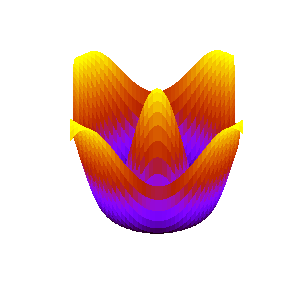

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from mpl_toolkits.mplot3d import Axes3D


# create a figure
fig = plt.figure()
# initialise 3D Axes
ax = Axes3D(fig)
# remove background grid, fill and axis
ax.grid(False)
ax.xaxis.pane.fill = ax.yaxis.pane.fill = ax.zaxis.pane.fill = False
plt.axis('off')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
xx, yy = np.meshgrid(X, Y)
r = np.sqrt(xx**2 + yy**2)
z = np.cos(r)


# create the initialiser with the surface plot
def init():
    ax.plot_surface(xx, yy, z, cmap=cm.gnuplot,
                    linewidth=0, antialiased=False)
    return fig,


# create animate function, this will adjust the view one step at a time
def animate(i):
    ax.view_init(elev=30.0, azim=i)
    return fig,


# create the animated plot
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# save as a GIF
anim.save('surface_rotation.gif', fps=30, writer='imagemagick')